# Course Project

## Setup

In [1]:
import os
import math
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing as sklearn_preprocessing
import tensorflow as ts
import tensorflow.keras as keras
import librosa as lr
import soundfile as sf
from tqdm import tqdm

In [2]:
dataset = []
sr = 22050//4
for file in os.listdir('audio'):
    data, sr = lr.load(f'./audio/{file}', sr=None)
    dataset.append(data)
dataset = np.array(dataset, dtype=object)

In [3]:
scaler = sklearn_preprocessing.StandardScaler()

## Utility functions

In [4]:
def plot_sample(sample):
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(sample.shape[0]), sample)

def plot_samples(samples):
  colors = 'rgbm'
  if len(samples) > 4:
    raise Exception('Нюхай бебру більше 4 графіків не намалюю')
  plt.figure(figsize=(12, 6))
  for i, sample in enumerate(samples):
    plt.plot(np.arange(sample['data'].shape[0]), sample['data'], colors[i], label=sample['label'])
  plt.legend()

In [5]:
def cut_audio(audio, start, length):
  res = np.copy(audio)
  start = int(start * sr)
  length = int(length * sr)
  res[start:start + length] = 0.0
  return res

In [6]:
def restore_audio(audio_data):
  return scaler.inverse_transform(audio_data.reshape(audio_data.shape[0], 1)).reshape(-1)

In [7]:
def write_audio(filename, audio_data, sample_rate):
  sf.write(filename, audio_data, sample_rate, 'PCM_24')

## Train / validation data preparation

In [8]:
seq_size = 50

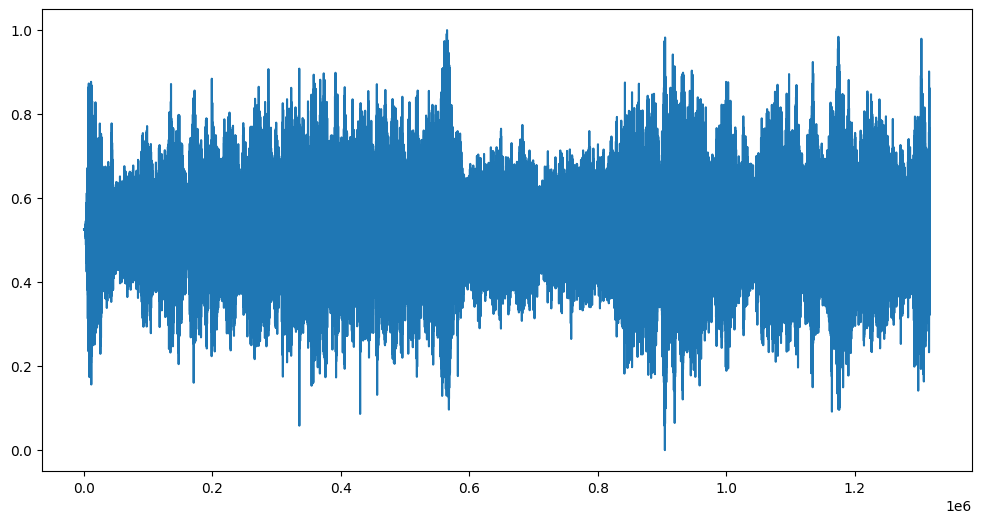

In [9]:
plot_sample(dataset[0])

In [10]:
def sequentialize_sample(sample):
  X = []
  y = []
  for i in range(sample.shape[0]-seq_size-1):
      window = sample[i:(i+seq_size)]
      X.append(window)
      y.append(sample[i+seq_size])

  X = np.array(X)
  X = X.reshape(X.shape[0], 1, X.shape[1])
  y = np.array(y)

  return X, y

In [11]:
def prepare_sample(sample):
  return sequentialize_sample(sample)

In [12]:
sample_duration = 6.0

In [13]:
def preprocess_dataset(dataset):
    # TODO: This assumes we only have one track to scale, otherwise this is garbage code
    for i, track in enumerate(dataset):
        dataset[i] = scaler.fit_transform(track.reshape(track.shape[0], 1)).reshape(-1)
    return dataset


In [14]:
def cut_samples(dataset):
    samples = []
    for track in dataset:
        track_len = int(track.shape[0] // sr)
        for i in range(0, track_len - math.ceil(sample_duration), math.ceil(sample_duration)):
            start = int(i * sr)
            finish = int(start + sr * sample_duration)
            samples.append(track[start:finish])
            break
    return np.array(samples, dtype=np.float32)

In [15]:
samples = cut_samples(preprocess_dataset(dataset))

## Model training

In [16]:
X, y = prepare_sample(samples[0])
X = X.reshape((X.shape[0], X.shape[2]))
X.shape, y.shape

((132249, 50), (132249,))

In [20]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [18]:
epochs = 7
batch_size = 256

In [19]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True,
          ), input_shape=(None, seq_size)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1, activation='linear'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()
for i, sample in enumerate(samples):
    print(f'Fitting sample {i + 1} / {samples.shape[0]}')
    X_train, y_train = prepare_sample(sample)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, None, 256)        183296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                        

KeyboardInterrupt: 

## Test results

In [21]:
cut_duration = 0.5
cut_start = 3.5

In [22]:
def cut_sample(sample):
  sample_cut = np.copy(sample)
  start = cut_start
  if start == None:
    start = random.uniform(0.0, sample_cut.shape[0])
  end = start + cut_duration
  start = int(start * sr)
  end = int(end * sr)
  sample_cut[start:end] = 0.0
  return sample_cut, range(start, end)

(88149,)


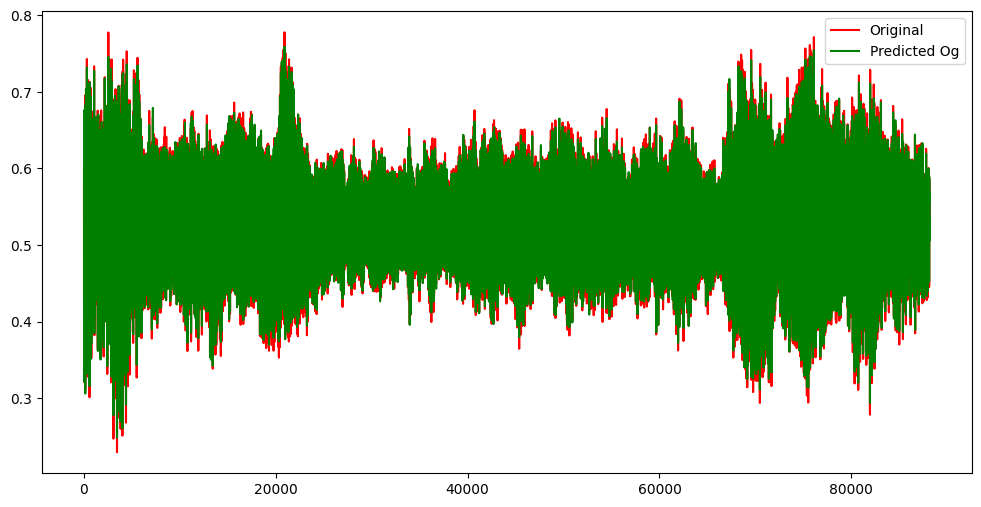

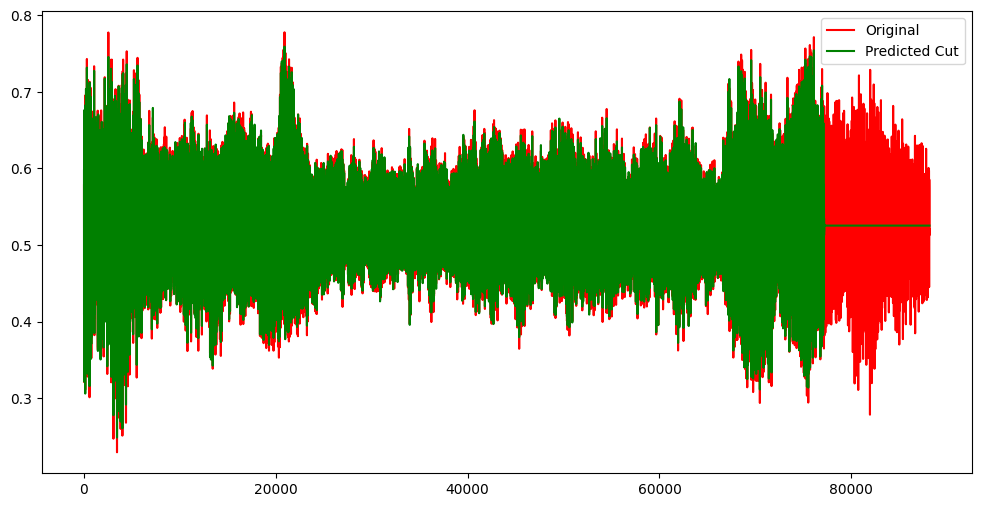

In [23]:
try:
    shutil.rmtree('compare')
except:
    pass  
os.makedirs('compare')

samples_to_plot = [0]
for i in samples_to_plot:
    sample_og = samples[i][sr * 1:sr * 5]
    sample_cut, cut_range = cut_sample(sample_og)
    
    X_test, _ = prepare_sample(sample_og)
    y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[2])))
    
    X_test_cut, _ = prepare_sample(sample_cut)
    window_cut = np.array([[sample_og[int(sr * cut_start) - seq_size:int(sr * cut_start)]]])
    # y_pred_cut = []
    # for j in range(int(sr * cut_start)):
    #     y_pred_cut.append(sample_og[j])
    y_pred_cut = model.predict(X_test_cut.reshape((X_test_cut.shape[0], X_test_cut.shape[2])))
    # iter = 60
    # for j in tqdm(range(int(sr * cut_start), int(sr * (cut_start + cut_duration)) - seq_size)):
    #     y_pred_cut.append(model.predict(window_cut[0]))
    #     y_pred_cut[-1] = y_pred_cut[-1][0]
    #     # if iter > 0:
    #     #     print(f'prediction = {y_pred_cut[-1]}')
    #     #     print(f'window = {window_cut}')
    #     # else:
    #     #     break
    #     window_cut = np.roll(window_cut, -1)
    #     window_cut[0][0][-1] = y_pred_cut[-1]
    #     iter -= 1
    # y_pred_cut = np.array(y_pred_cut)
    print(y_pred_cut.shape)

    og = restore_audio(sample_og[seq_size:])
    cut = restore_audio(sample_cut[seq_size:])
    pred = restore_audio(y_pred)
    pred_cut = restore_audio(y_pred_cut)
    
    plot_samples([
        { 'data': og, 'label': 'Original' },
        { 'data': pred, 'label': 'Predicted Og' },
    ])
    plot_samples([
        { 'data': og, 'label': 'Original' },
        { 'data': pred_cut, 'label': 'Predicted Cut' },
    ])

    write_audio(f'compare/{i}_sample_og.wav', og, sr)
    write_audio(f'compare/{i}_sample_cut.wav', cut, sr)
    write_audio(f'compare/{i}_sample_pred.wav', pred, sr)
    write_audio(f'compare/{i}_sample_pred_cut.wav', pred_cut, sr)
    